## License Information
---

This file is distributed as part of `swprocess`, a Python package for surface wave processing.

    Copyright (C) 2020 Joseph P. Vantassel (jvantassel@utexas.edu)

    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <https: //www.gnu.org/licenses/>.
    
## About _swprocess_ and this notebook
---

`swprocess` is a Python package for surface wave processing. `swprocess` was developed by
Joseph P. Vantassel under the supervision of Professor Brady R. Cox at The University of
Texas at Austin.

If you use _swprocess_ in your research or consulting, we ask you please cite the following:

__TBD__

<!-- >Joseph Vantassel. (2020). jpvantassel/hvsrpy: latest (Concept). Zenodo.
[http://doi.org/10.5281/zenodo.3666956](http://doi.org/10.5281/zenodo.3666956)
 _Note: For software, version specific citations should be preferred to
general concept citations, such as that listed above. To generate a version
specific citation for `hvsrpy`, please use the citation tool on the `hvsrpy`
[archive](http://doi.org/10.5281/zenodo.3666956)._
 -->

<!-- The automated frequency-domain window-rejection algorithm and log-normal statistics
implemented in `hvsrpy` were developed by Tianjian Cheng under the supervision of
Professor Brady R. Cox at The University of Texas at Austin. To
recognize their original work please cite the follwing:

> Cox, B. R., Cheng, T., Vantassel, J. P., and Manuel, L. (2020). “A statistical
> representation and frequency-domain window-rejection algorithm for single-station
> HVSR measurements.” Geophysical Journal International, 221(3), 2170-2183.

This notebook also provides automatic checking of the SESAME (2004) reliability
and clarity critera. To recognize their original work please also cite the following:

> SESAME. (2004). Guidelines for the Implementation of the H/V Spectral Ratio Technique on Ambient Vibrations
> Measurements, Processing, and Interpretation. European Commission - Research General Directorate, 62,
> European Commission - Research General Directorate.
 -->
 
## Getting Started
---
1. Install _swprocess_ and its dependencies, with `pip install swprocess`. If you are not familiar with `pip`, a useful tutorial can be found [here](https://jpvantassel.github.io/python3-course/#/intro/pip). __(~3 minutes)__ 

__TBD__

Happy Processing!

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import swprocess
import swprepost

## Input
---

### Files

In [11]:
# File(s) to import.
fnames_set = [
    ["../masw/wghs_masw.json"],
    ["../mam/wghs_rayleigh_c50.json"],
    ["../mam/wghs_rayleigh_bigx.json"]
    ]

# fnames_set = [
#     ["wghs_processed_masw.json"],
#     ["wghs_processed_c50.json"],
#     ["wghs_processed_bigx.json"]
#     ]

### Plot Settings

In [12]:
# Domains in which to plot the experimental dispersion data.
domains = [
    ["frequency", "velocity"],
    ["wavelength", "velocity"],
]

# Colors (in hexidecimal) one per `fnames_set` entry.
colors = ["#acacef", "#efacef", "#acdeff"]

# Labels one per `fnames_set` entry.
labels = ["MASW - R0", "MAM - C50", "MAM - BigX"]

## View Raw Data
---

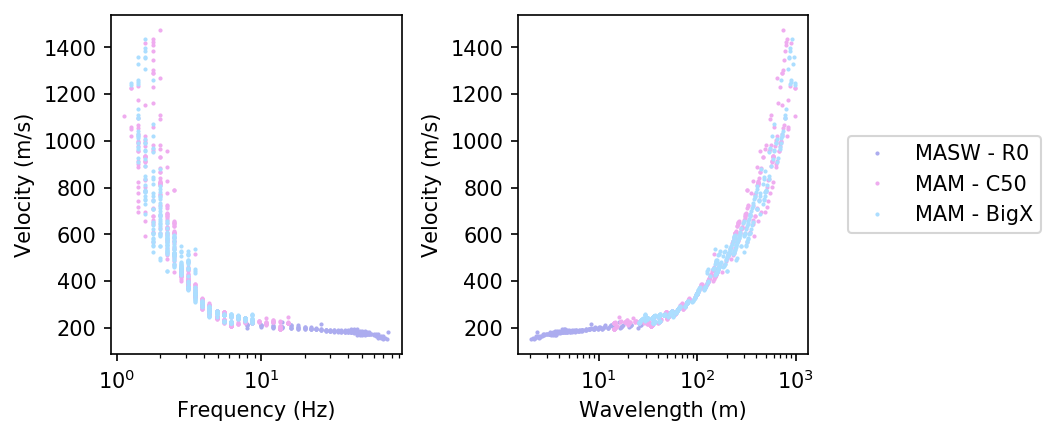

In [13]:
%matplotlib inline
xtype = [x for x, _ in domains]
ytype = [y for _, y in domains]

if len(fnames_set) != len(colors) or len(fnames_set) != len(labels):
    raise IndexError(f"fnames_set, colors, and labels must be the same length.")

fig, axs = plt.subplots(ncols=len(xtype), figsize=(6,3), dpi=150, gridspec_kw=dict(wspace=0.4))
suites = []
for fnames, color, label in zip(fnames_set, colors, labels):
    peaksuite = swprocess.PeaksSuite.from_json(fnames=fnames)
    peaksuite.plot(xtype=xtype, ax=axs, ytype=ytype, plot_kwargs=dict(color=color, label=label))
    suites.append(peaksuite)
    
axs[-1].legend(bbox_to_anchor = (1.1, 0.5), loc="center left")

plt.show()

master_suite = swprocess.PeaksSuite.from_peakssuite(suites)
_colors, _labels = [], []
for color, label, suite in zip(colors, labels, suites):
    for _ in range(len(suite)):
        _colors.append(color)
        _labels.append(label)
        label = None

## Interactive Trimming
---

### Workflow

In [14]:
# Workflow for interactive trimming {"individual", "together"}, "individual" is recommended.
workflow = "individual" 

### Array Resolution Limits

In [15]:
# Resolution limits, one per entry in fnames_set. Ingored if workflow="together".
individual_resolution_limits = [
    ["wavelength", (2, 50)],
    ["wavenumber", (0.103/2, 0.246*2)],
    ["wavenumber", (0.0639154/2, 0.12635*2)],
    ]

# Overall minimumm and maximum array resolution, only one entry permitted.
overall_resolution_limits = ["wavenumber", (0.103/2, 2*np.pi/2)]

### Bulk Trimming

In [16]:
# Bulk remove points outside of the specified screening criteria. Use `None` for one sided intervals. Multiple entries permitted.
bulk_trimming_limits = {
    "velocity" : [None, 2500],
    "wavelength" : [None, 1000]
}

### Launch

In [ ]:
%matplotlib qt5
for suite in suites:
    for attribute, limits in bulk_trimming_limits.items():
        suite.blitz(attribute, limits)        

if workflow == "individual":
    if len(fnames_set) != len(individual_resolution_limits):
        raise IndexError(f"individidual_resolution_limits must have the same length as fnames_set.")

    for suite, color, label, _resolution_limits in zip(suites, colors, labels, individual_resolution_limits):
        suite.interactive_trimming(xtype=xtype, ytype=ytype, plot_kwargs=dict(color=color, label=label), resolution_limits=_resolution_limits)

master_suite.interactive_trimming(xtype=xtype, ytype=ytype, plot_kwargs=dict(color=_colors, label=_labels), resolution_limits=overall_resolution_limits)

## Plot Data Post Trimming
---

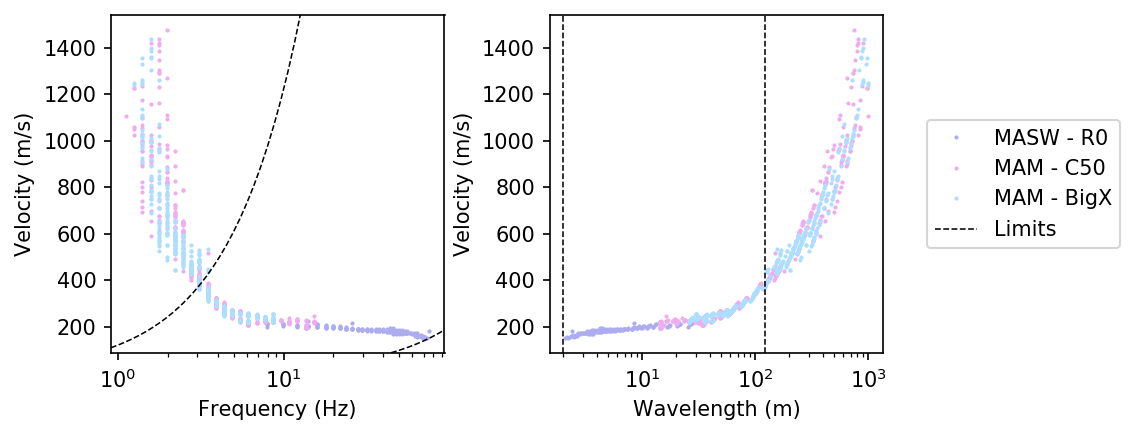

In [17]:
%matplotlib inline
fig, axs = master_suite.plot(xtype=xtype, ytype=ytype, plot_kwargs=dict(color=_colors, label=_labels))

for ax, _xtype, _ytype in zip(axs, xtype, ytype):
    ax.autoscale(enable=False)
    attribute, limits = overall_resolution_limits
    master_suite.plot_resolution_limits(ax=ax, xtype=_xtype, ytype=_ytype, attribute=attribute, limits=limits, plot_kwargs=dict(label="Limits"))
    
axs[-1].legend(bbox_to_anchor = (1.1, 0.5), loc="center left")

plt.show()

## Statistics
---

TODO (jpv)
- Number of points

### Input

In [18]:
# Domain in which to calculate statistics.
xdomain, ydomain = "wavelength", "velocity"

# Statistic calculation points.
xmin, xmax, nx, xspace = 1, 1000, 40, "log"

### Plot

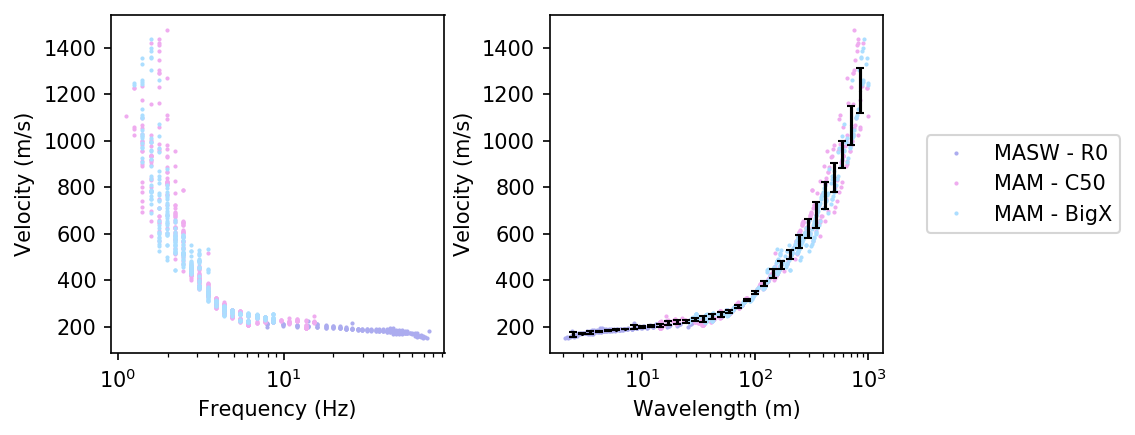

In [19]:
%matplotlib inline

xx = swprocess.wavefieldtransforms.AbstractWavefieldTransform._create_vector(pmin=xmin, pmax=xmax, pn=nx, pspace=xspace)
xx, mean, stddev, _ = master_suite.statistics(xtype=xdomain, ytype=ydomain, xx=xx, ignore_corr=True)

fig, axs = master_suite.plot(xtype=xtype, ytype=ytype, plot_kwargs=dict(color=_colors, label=_labels))

for ax, _xtype, _ytype in zip(axs, xtype, ytype):
    if _xtype == xdomain and _ytype == ydomain:
        master_suite.plot_statistics(ax=ax, xx=xx, mean=mean, stddev=stddev)

axs[-1].legend(bbox_to_anchor = (1.1, 0.5), loc="center left")

plt.show()

### Write to `.target`

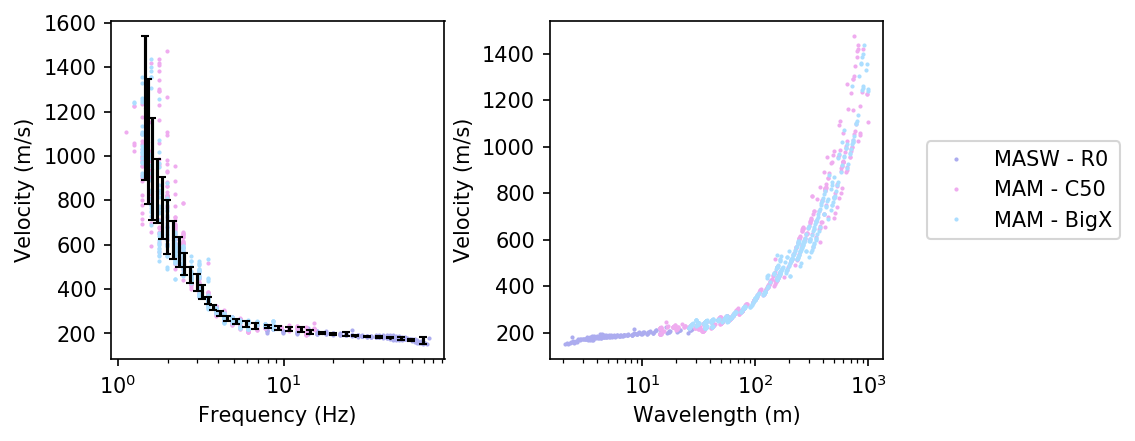

In [20]:
fname_prefix = "example"
version = "2"

if xdomain == "frequency" and ydomain == "velocity":
    new_xx = np.array(xx)
    new_mean = np.array(mean)
    new_stddev = np.array(stddev)
elif xdomain == "wavelength" and ydomain == "velocity":
    new_xx = mean/xx
    new_mean = np.array(mean)
    upper = swprepost.Curve(x=(mean+stddev)/xx, y=mean+stddev)
    lower = swprepost.Curve(x=(mean-stddev)/xx, y=mean-stddev)
    new_stddev = ((upper.resample(xx=new_xx, interp1d_kwargs=dict(fill_value="extrapolate"))[1] - new_mean) + (new_mean - lower.resample(xx=new_xx, interp1d_kwargs=dict(fill_value="extrapolate"))[1])) /2
else:
    raise NotImplementedError()
    
%matplotlib inline
fig, axs = master_suite.plot(xtype=xtype, ytype=ytype, plot_kwargs=dict(color=_colors, label=_labels))

for ax, _xtype, _ytype in zip(axs, xtype, ytype):
    if _xtype == "frequency" and _ytype == "velocity":
        master_suite.plot_statistics(ax=ax, xx=new_xx, mean=new_mean, stddev=new_stddev)

axs[-1].legend(bbox_to_anchor = (1.1, 0.5), loc="center left")
plt.show()

target = swprepost.Target(frequency=new_xx, velocity=new_mean, velstd=new_stddev)
target.to_target(fname_prefix=fname_prefix, version=version)

## Write to trimmed data to `.json`
---

### Input

In [21]:
# File contents {"together", "indivdual"}. "together" all sets are combined into a single file. "individual" all sets are saved to separate files.
file_contents = "individual"

# Output prefix.
output_prefix = "wghs_processed"

# If file_contents == "indivdual", define unique suffixes for each output file.
output_suffixes = ["masw", "c50", "bigx"]

### Write

In [22]:
if file_contents == "together":
    master_suite.to_json(f"{output_prefix}.json")
else:
    if len(output_suffixes) != len(suites):
        raise IndexError(f"suites and indivdual suffixes are of different length.")
    for suite, suffix in zip(suites, output_suffixes):
        suite.to_json(f"{output_prefix}_{suffix}.json")